# Lab 5 - analisis de paquetes en la red IDS
Sergio Marchena -16387

2022

In [1]:
pip install scapy

     |████████████████████████████████| 1.1 MB 5.0 MB/s 
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261555 sha256=a95b8da4c3dd56e91ad1b9f2e9218fe200755195dc9a1cf9bc650a3f0bedd6ab
  Stored in directory: /root/.cache/pip/wheels/b9/6e/c0/0157e466a5e02d3ff28fc7587dff329b4a967a23b3f9b11385
Successfully built scapy


In [2]:
#pip install hvplot

In [3]:
from scapy.all import * # Packet manipulation
import pandas as pd 
import numpy as np
import binascii # Binary to Ascii 
import seaborn as sns
#import hvplot.pandas
#import holoviews as hv
#hv.extension('bokeh')

## 1. Capture 100 paquetes con la herramienta scapy, imprima el tipo de datos, la longitud y el  contenido del pcap.

In [101]:
num_of_packets_to_sniff = 10
pcap = sniff(count=num_of_packets_to_sniff)

print(type(pcap))
print(len(pcap))
print(pcap)

<class 'scapy.plist.PacketList'>
10
<Sniffed: TCP:10 UDP:0 ICMP:0 Other:0>


## 2. Añada al pcap de 100 paquetes el archivo analisis_paquetes.pcap 

In [102]:
# ?
f = rdpcap("/content/drive/MyDrive/UVG /2022/SECURITY DATA SCIENCE/LAb5/analisis_paquetes.pcap")
nuevo_PCAP = pcap + f

nuevo_PCAP

<Sniffed+analisis_paquetes.pcap: TCP:10 UDP:62 ICMP:0 Other:0>

## 3. Convierta el pcap a un DataFrame.

In [103]:
from scapy.layers.l2 import Ether
from scapy.layers.inet import IP,TCP, UDP

In [104]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in nuevo_PCAP[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

df

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,450,25647,DF,0,64,6,31947,...,8,0,PA,501,23024,0,3,398,b'GET /socket.io/?EIO=3&sid=70SBRrm1txUmLPK3AA...,b'474554202f736f636b65742e696f2f3f45494f3d3326...
1,4,5,0,52,6196,DF,0,64,6,51796,...,8,0,A,501,22626,0,3,0,b'',b''
2,4,5,0,772,6197,DF,0,64,6,51075,...,8,0,PA,501,23346,0,3,720,b'HTTP/1.1 200 OK\r\nContent-Type: text/plain;...,b'485454502f312e3120323030204f4b0d0a436f6e7465...
3,4,5,0,52,25648,DF,0,64,6,32344,...,8,0,A,501,22626,0,3,0,b'',b''
4,4,5,0,554,25649,DF,0,64,6,31841,...,8,0,PA,501,23128,0,3,502,b'POST /socket.io/?EIO=3&sid=70SBRrm1txUmLPK3A...,b'504f5354202f736f636b65742e696f2f3f45494f3d33...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,4,5,32,84,8744,,0,122,17,64011,...,None,None,None,None,65088,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
68,4,5,0,969,1,,0,64,17,21214,...,None,None,None,None,671,None,None,941,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
69,4,5,32,84,9344,,0,122,17,63411,...,None,None,None,None,65089,None,None,56,b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...,b'000c8180000100010000000006676f6f676c6503636f...
70,4,5,0,588,1,,0,64,17,21595,...,None,None,None,None,54406,None,None,560,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


## 4. Muestre los valores de las columnas: Src Addres, Dst Address, Src Port y Dst Port 

In [105]:
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,172.28.0.1,172.28.0.2,56206,8080
1,172.28.0.2,172.28.0.1,8080,56206
2,172.28.0.2,172.28.0.1,8080,56206
3,172.28.0.1,172.28.0.2,56206,8080
4,172.28.0.1,172.28.0.2,56206,8080
...,...,...,...,...
67,84.54.22.33,10.1.10.53,53,53
68,10.1.10.53,84.54.22.33,53,53
69,84.54.22.33,10.1.10.53,53,53
70,10.1.10.53,84.54.22.33,53,53


## 5. Estadísticas 

### a. Muestre cual es la IP origen que más aparece 

In [106]:
print('\tIP \tVeces')
df['src'].value_counts()

	IP 	Veces


10.1.10.53     31
84.54.22.33    29
172.28.0.1      5
172.28.0.2      5
75.75.75.75     2
Name: src, dtype: int64

### b. Muestre cual es la IP destino que más aparece 

In [107]:
print('\tIP \tVeces')
df['dst'].value_counts()

	IP 	Veces


10.1.10.53     31
84.54.22.33    29
172.28.0.2      5
172.28.0.1      5
75.75.75.75     2
Name: dst, dtype: int64

### c. ¿A qué IPs se comunica la IP del inciso a? 

In [108]:
df[['src','dst']][df['src'] == '10.1.10.53'].value_counts()

src         dst        
10.1.10.53  84.54.22.33    29
            75.75.75.75     2
dtype: int64

### d. ¿A qué puertos destino se comunica la IP del inciso a? 

In [109]:
print('Puerto  Veces')
df['dport'][df['src'] == '10.1.10.53'].value_counts()

Puerto  Veces


53    31
Name: dport, dtype: int64

### e. ¿A qué puertos origen se comunica la IP del inciso a? 

In [110]:
print('Puerto  Veces')
df['sport'][df['src'] == '10.1.10.53'].value_counts()

Puerto  Veces


53       29
15812     1
23903     1
Name: sport, dtype: int64

### f. ¿Para que se utiliza el puerto que más aparece en el inciso  d y e? 

In [14]:
# 53

Se usa para resolucion de DNS.

DNS utiliza el puerto 53, que casi siempre está abierto en los sistemas, firewalls y clientes para transmitir consultas de DNS. En lugar del TCP, estas consultas utilizan el Protocolo UDP debido a su baja latencia, ancho de banda y uso de recursos en comparación con las consultas equivalentes a TCP. UDP no tiene capacidades de control de flujo o error, ni tiene ninguna verificación de integridad para garantizar que los datos lleguen intactos.

## 6. Gráficas 

### a. Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads enviados de dichas direcciones. 

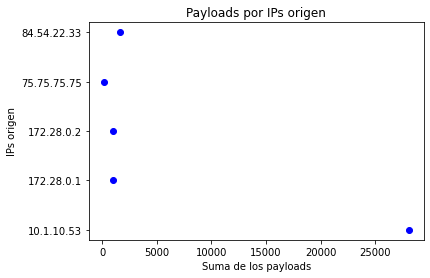

In [111]:
graph1 = df[['src','payload']]
graph1 = graph1.groupby('src').sum()
graph1 = graph1.reset_index()
#####
plt.scatter(x=graph1.payload, y=graph1.src, color='blue')
plt.title("Payloads por IPs origen")
plt.xlabel("Suma de los payloads")
plt.ylabel("IPs origen")
plt.show()

### b. Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads recibidos en dichas direcciones. 

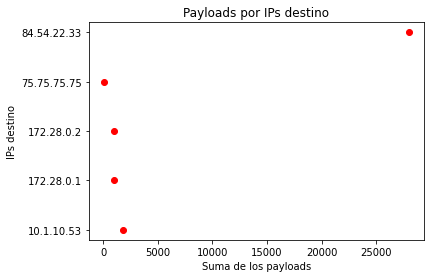

In [112]:
graph1 = df[['dst','payload']]
graph1 = graph1.groupby('dst').sum()
graph1 = graph1.reset_index()
#####
plt.scatter(x=graph1.payload, y=graph1.dst, color='red')
plt.title("Payloads por IPs destino")
plt.xlabel("Suma de los payloads")
plt.ylabel("IPs destino")
plt.show()

### c. Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los payloads enviados de dichos puertos. 

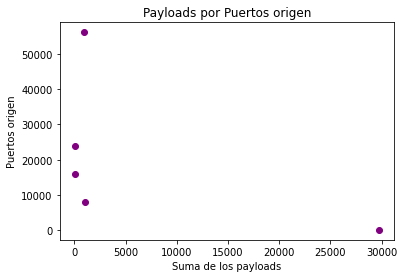

In [113]:
graph1 = df[['sport','payload']]
graph1 = graph1.groupby('sport').sum()
graph1 = graph1.reset_index()
#####
plt.scatter(x=graph1.payload, y=graph1.sport, color='purple')
plt.title("Payloads por Puertos origen")
plt.xlabel("Suma de los payloads")
plt.ylabel("Puertos origen")
plt.show()

### d. Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los payloads recibidos en dichos puertos. 

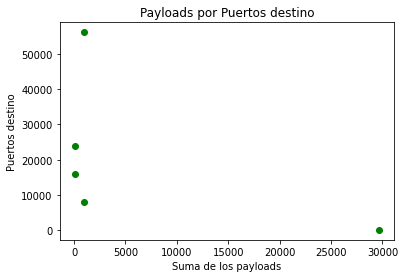

In [114]:
graph1 = df[['dport','payload']]
graph1 = graph1.groupby('dport').sum()
graph1 = graph1.reset_index()
#####
plt.scatter(x=graph1.payload, y=graph1.dport, color='green')
plt.title("Payloads por Puertos destino")
plt.xlabel("Suma de los payloads")
plt.ylabel("Puertos destino")
plt.show()

## 7. Investigación del payload 

### a. Cree un nuevo DF que incluya únicamente la conversación de la dirección IP origen más frecuente 

In [115]:
freq_ip = df['src'].mode()
freq_ip_df = df[df['src'] == freq_ip[0]]
freq_ip_df = freq_ip_df.reset_index(drop=True)
freq_ip_df.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
1,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
2,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
3,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


### b. Obtenga un nuevo DF con las columnas Src Address, Dst Address y agrúpelas por payload 

In [131]:
weird_df = freq_ip_df[['src', 'dst', 'payload', 'payload_raw']]
weird_df.head()

,src,dst,payload,payload_raw
0,10.1.10.53,84.54.22.33,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
1,10.1.10.53,84.54.22.33,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
2,10.1.10.53,84.54.22.33,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
3,10.1.10.53,84.54.22.33,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
4,10.1.10.53,84.54.22.33,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...


In [132]:
hm = weird_df.groupby('payload')

### c. Obtenga la IP que más ha intercambiado bytes con la IP más frecuente.  Esta IP es sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.  

In [133]:
frequent_address_groupby = weird_df[['src','dst','payload']].groupby("dst")['payload'].sum()

In [134]:
frequent_address_groupby

dst
75.75.75.75       74
84.54.22.33    27979
Name: payload, dtype: object

### d. Cree un nuevo DF con la conversación entre la IP más frecuenta y la IP sospechosa. 

In [136]:
suspicious_df = weird_df[weird_df['dst']=='84.54.22.33']
suspicious_df

,src,dst,payload,payload_raw
0,10.1.10.53,84.54.22.33,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
1,10.1.10.53,84.54.22.33,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
2,10.1.10.53,84.54.22.33,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
3,10.1.10.53,84.54.22.33,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
4,10.1.10.53,84.54.22.33,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
5,10.1.10.53,84.54.22.33,1017,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
6,10.1.10.53,84.54.22.33,980,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
7,10.1.10.53,84.54.22.33,951,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
8,10.1.10.53,84.54.22.33,931,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...
9,10.1.10.53,84.54.22.33,964,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...


### e. Obtenga los payloads del DF del inciso d, y añada cada uno en un array. 

In [143]:
suspicius_array = suspicious_df.iloc[:,3:].values

### f. Muestre el contenido del array

In [144]:
suspicius_array

array([[b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd

### g. Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido que se envie a través del puerto explicado en el inciso f? 

SI. Se supone que el puerto 53 se usa para resolucion de puertos DNS. Pero en la primer entrada del payload, se ecuentra en la direccion la palabra "PNG". La cual indica que un archivo se esta mandando por este puerto. Al igual se pueden econtrar palabras clave dentro del contenido

## Parte 2

In [25]:
import pandas as pd

In [26]:
# import file
df = pd.read_csv('/content/drive/MyDrive/UVG /2022/SECURITY DATA SCIENCE/LAb5/Train_data.csv')
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0,tcp,private,S0,0,0,0,0,0,0,...,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,23,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0,tcp,private,S0,0,0,0,0,0,0,...,13,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [27]:
# info of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [28]:
# to numeric: 
  # protocol_type
  # service
  # flag
  # class

In [29]:
df.protocol_type.value_counts()

tcp     20526
udp      3011
icmp     1655
Name: protocol_type, dtype: int64

In [30]:
# econding protocol type
labels, unique = df.protocol_type.factorize()
df.protocol_type = labels
df.protocol_type

0        0
1        1
2        0
3        0
4        0
        ..
25187    0
25188    0
25189    0
25190    0
25191    0
Name: protocol_type, Length: 25192, dtype: int64

In [31]:
df.service.value_counts()

http         8003
private      4351
domain_u     1820
smtp         1449
ftp_data     1396
             ... 
urh_i           4
red_i           3
pm_dump         3
tim_i           2
http_8001       1
Name: service, Length: 66, dtype: int64

In [32]:
# econding service
labels, unique = df.service.factorize()
df.service = labels
df.service

0         0
1         1
2         2
3         3
4         3
         ..
25187    43
25188     0
25189     2
25190    54
25191    10
Name: service, Length: 25192, dtype: int64

In [33]:
df.flag.value_counts()

SF        14973
S0         7009
REJ        2216
RSTR        497
RSTO        304
S1           88
SH           43
RSTOS0       21
S2           21
S3           15
OTH           5
Name: flag, dtype: int64

In [34]:
# econding flag
labels, unique = df.flag.factorize()
df.flag = labels
df.flag

0        0
1        0
2        1
3        0
4        0
        ..
25187    5
25188    0
25189    2
25190    1
25191    1
Name: flag, Length: 25192, dtype: int64

In [35]:
df['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

In [36]:
# econding class
labels, unique = df['class'].factorize()
df['class'] = labels
df['class']

0        0
1        0
2        1
3        0
4        0
        ..
25187    1
25188    1
25189    1
25190    1
25191    1
Name: class, Length: 25192, dtype: int64

In [37]:
df.info()
print('\nready to PCA!')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  int64  
 2   service                      25192 non-null  int64  
 3   flag                         25192 non-null  int64  
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [38]:
# View scatterplot
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

In [39]:
# Plot results
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [40]:
# Calculate reconstruction error
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

data separation 

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing as pp
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA

In [42]:
# Separating out the features
datax = df.drop(['class'],axis=1)
# Separating out the target
datay = df.loc[:,'class'].copy()
# Standardizing the features
#datax = StandardScaler().fit_transform(datax)

In [43]:
# TRAIN - TEST SPLIT
x_train,x_test,y_train, y_test = train_test_split(datax, datay, test_size=0.30,random_state=111)

In [44]:
# SCALER
featuresToScale = x_train.columns
sX = pp.StandardScaler(copy=True)
x_train.loc[:,featuresToScale] = sX.fit_transform(x_train.loc[:,featuresToScale])
x_test.loc[:,featuresToScale] = sX.transform(x_test.loc[:,featuresToScale])

In [45]:
# PCA
random_state = 123

pca = PCA(35, whiten=False,random_state=random_state)

x_train_PCA = pca.fit_transform(x_train)
x_train_PCA = pd.DataFrame(data=x_train_PCA, index=x_train.index)

x_train_PCA_inverse = pca.inverse_transform(x_train_PCA)
x_train_PCA_inverse = pd.DataFrame(data=x_train_PCA_inverse,index=x_train.index)

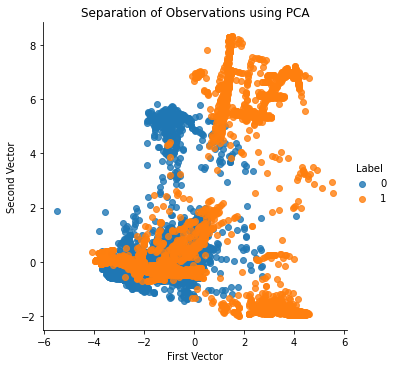

In [46]:
scatterPlot(x_train_PCA, y_train, "PCA")

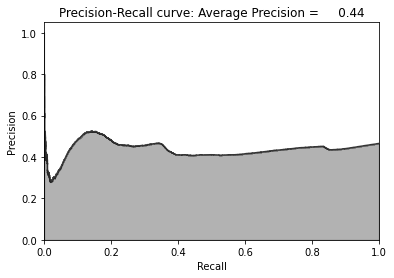

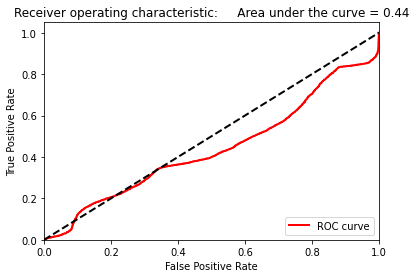

In [47]:
# View plot
anomalyScoresPCA = anomalyScores(x_train, x_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [48]:
x_train.shape, x_train_PCA.shape

((17634, 41), (17634, 35))

In [49]:
y_train.shape

(17634,)

In [50]:
x_test.shape

(7558, 41)

In [51]:
y_test.shape

(7558,)

In [52]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 5 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:4].sum(axis=1).values)
print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 15 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:14].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 25 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:24].sum(axis=1).values)
print('Variance Captured by First 30 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:29].sum(axis=1).values)
print('Variance Captured by First 35 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:34].sum(axis=1).values)
print('Variance Captured by First 40 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:39].sum(axis=1).values)

Variance Captured by First 5 Principal Components:  [0.52555469]
Variance Captured by First 10 Principal Components:  [0.69433996]
Variance Captured by First 15 Principal Components:  [0.82230334]
Variance Captured by First 20 Principal Components:  [0.91518158]
Variance Captured by First 25 Principal Components:  [0.96822606]
Variance Captured by First 30 Principal Components:  [0.99278642]
Variance Captured by First 35 Principal Components:  [0.99915138]
Variance Captured by First 40 Principal Components:  [0.99915138]


# REGRESION LOGISTICA SIN PCA

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [55]:
# SIN PCA 

logisticRegr.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [56]:
# Predict
y_pred = logisticRegr.predict(x_test)

In [57]:
from sklearn import metrics
# scores
print('N of components: ', x_train.shape[1])
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Matriz de confusion: \n',metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=['normal', 'anomaly']))

N of components:  41
Accuracy:  0.950648319661286
Matriz de confusion: 
 [[3844  178]
 [ 195 3341]]
              precision    recall  f1-score   support

      normal       0.95      0.96      0.95      4022
     anomaly       0.95      0.94      0.95      3536

    accuracy                           0.95      7558
   macro avg       0.95      0.95      0.95      7558
weighted avg       0.95      0.95      0.95      7558



# REGRESION LOGISTICA CON PCA

In [58]:
# CON PCA
logisticRegr.fit(x_train_PCA, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [59]:
x_test_PCA = pca.fit_transform(x_test)

In [60]:
# Predict for One Observation (image)
y_pred = logisticRegr.predict(x_test_PCA)

In [61]:
# scores
print('N of components: ', x_train_PCA.shape[1])
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Matriz de confusion: \n',metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred, target_names=['normal', 'anomaly']))

N of components:  35
Accuracy:  0.44112198994442975
Matriz de confusion: 
 [[1025 2997]
 [1227 2309]]
              precision    recall  f1-score   support

      normal       0.46      0.25      0.33      4022
     anomaly       0.44      0.65      0.52      3536

    accuracy                           0.44      7558
   macro avg       0.45      0.45      0.42      7558
weighted avg       0.45      0.44      0.42      7558



Conlusion: 

Como se puede observar el modelo con menor numero de feautures (el PCA) tiene una precision muy baja comparada con el modelo sin ninguna reduccion de dimensionalidad. El modelo con PCA tiene una precision de 44% y el modelo sin PCA tiene 95%. 
* Los valores de precision del modelo con PCA estan por 45% mientras que el modelo sin PCA tiene valores de precision de 95%. 
* Los valores de recall del modelo con PCA para clasificar trafico normal es de 25% y para anomalias el 65%, por lo que es un poco mejor. El modelo sin PCA tiene 95% en promedio para ambos casos.
* El modelo con PCA tiene un valor de f1 para trafico normal de 33% y un 52% de deteccion de anomalias, por lo que aproximadamente clasifica 1/2 anomalias de forma correcta. Mientras que el modelo sin PCA tiene 95% de f1-score. 

En conclusion, para este modelo de regresion logistica, el PCA no ayudó si no perjudicó al modelo y no se recomienda. 